<a href="https://colab.research.google.com/github/Rainniee/Neural-Networks-AI/blob/master/Experiment1_GloVe%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries and Glove

In [31]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import itertools
import os

import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras import optimizers

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.datasets import imdb
from tensorflow import keras
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, Activation, Dropout
from keras.layers import LSTM, CuDNNLSTM

from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing import text, sequence
from keras import utils
from tensorflow.keras.callbacks import EarlyStopping

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import seaborn as sns
sns.set()

You have TensorFlow version 1.13.1


In [3]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip

--2019-03-28 02:31:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-03-28 02:31:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M   758KB/s    in 7m 27s  

2019-03-28 02:38:57 (1.84 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### Explore the dataset

In [4]:
from google.colab import files
upload = files.upload()

Saving cleanedfinancial_data.csv to cleanedfinancial_data (2).csv


In [37]:
dataset = pd.read_csv("cleanedfinancial_data.csv")
dataset.head()

,sentiment,text
0,neutral,"Good day, ladies and gentlemen, and welcome to..."
1,negative,I'm not sure. I think Model T was a little bit...
2,negative,"Well, we need to bring the Shanghai factory on..."
3,neutral,So it's - it is eligible for that. But it soun...
4,positive,The demand for - the demand for Model 3 is ins...


In [38]:
# Value Counts
dataset.sentiment.value_counts()

neutral     838
positive    654
negative    157
Name: sentiment, dtype: int64

In [39]:
dataset.shape[0]

1649

In [40]:
dataset.iloc[2,1]

"Well, we need to bring the Shanghai factory online. I think that's the biggest driver for getting to 500K plus a year. Our car is just very expensive going into China. We've got import duties. We've got transport costs. We've got higher-cost labor here. And we've never been eligible for any of the EV tax credits. A lot of people sort of dependent on incentives. In fact, we are [indiscernible] EVs, we have the least access to incentives. It's pretty crazy because there's so many companies that - countries that have put price caps on the EV incentive, which affects Tesla. And in China, which is the biggest market for EVs, we've never had any subsidies or tax incentives for vehicles."

### Tokenize the data

In [41]:
import re
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize as wt 

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

#spell correction
# import autocorrect
# from autocorrect. import spell

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
dataset.shape

(1649, 2)

In [0]:
data = []

financial_test = dataset[dataset['sentiment'] != 'neutral']

for i in range(financial_test.shape[0]):
    sms = financial_test.iloc[i, 1]

    # remove non alphabatic characters
    sms = re.sub('[^A-Za-z]', ' ', sms)

    # make words lowercase, because Go and go will be considered as two words
    sms = sms.lower()

    # tokenising
    tokenized_sms = wt(sms)

    # remove stop words and stemming
 
    sms_processed = []
    for word in tokenized_sms:
        if word not in set(stopwords.words('english')):
            sms_processed.append(stemmer.stem(word))

    sms_text = " ".join(sms_processed)
    data.append(sms_text)

In [46]:
financial_test['sentiment'] = financial_test['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

X = tokenizer.texts_to_matrix(financial_test['text'].tolist(), mode='freq')
y = np.asarray(financial_test['sentiment'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 2000

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Pad sequences (samples x time)
x_train shape: (648, 2000)
x_test shape: (163, 2000)
y_train shape: (648,)
y_test shape: (163,)


### Build Model

In [50]:
embeddings_index = {}

with open('glove.6B.100d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# set dimemsions (# features for each word vector) for embedding layer
embedding_dim = 2000
tokenizer = Tokenizer(num_words=max_words)
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [61]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, weights = [embedding_matrix], trainable = False, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2000, 2000)        3898000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 4000000)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                128000032 
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 131,898,065
Trainable params: 128,000,065
Non-trainable params: 3,898,000
_________________________________________________________________


In [62]:
%%time
epochs = 5
batch_size = 128
validation_split = 0.2

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size,
          epochs=epochs, 
          validation_split=validation_split)


Train on 518 samples, validate on 130 samples
Epoch 1/5
518/518 [==============================] - 10s 20ms/step - loss: 0.6918 - acc: 0.6699 - val_loss: 0.6898 - val_acc: 0.8000
Epoch 2/5
518/518 [==============================] - 9s 17ms/step - loss: 0.6889 - acc: 0.8282 - val_loss: 0.6883 - val_acc: 0.8000
Epoch 3/5
518/518 [==============================] - 9s 17ms/step - loss: 0.6873 - acc: 0.8282 - val_loss: 0.6867 - val_acc: 0.8000
Epoch 4/5
518/518 [==============================] - 9s 17ms/step - loss: 0.6855 - acc: 0.8282 - val_loss: 0.6851 - val_acc: 0.8000
Epoch 5/5
518/518 [==============================] - 9s 17ms/step - loss: 0.6838 - acc: 0.8282 - val_loss: 0.6837 - val_acc: 0.8000
CPU times: user 18.7 s, sys: 11.9 s, total: 30.6 s
Wall time: 45.3 s


In [63]:
score, acc = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (acc*100))
print("Test score: %.2f%%" % (score*100))

Accuracy: 74.23%
Test score: 68.55%


0.7423312883435583
              precision    recall  f1-score   support

         pos       0.00      0.00      0.00        42
         neg       0.74      1.00      0.85       121

   micro avg       0.74      0.74      0.74       163
   macro avg       0.37      0.50      0.43       163
weighted avg       0.55      0.74      0.63       163

[[  0  42]
 [  0 121]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


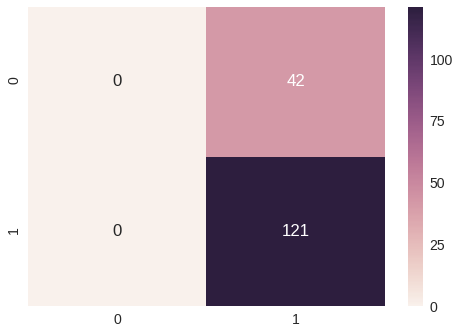

In [64]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict_classes(np.array(x_test))

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
target_names = ['pos', 'neg']
cnf_matrix_test = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=target_names))
print(cnf_matrix_test)

df_cm = pd.DataFrame(cnf_matrix_test, range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d')

In [65]:
TP = cnf_matrix_test[1, 1]
TN = cnf_matrix_test[0, 0]
FP = cnf_matrix_test[0, 1]
FN = cnf_matrix_test[1, 0]

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)

0.25766871165644173
